In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Merge historical data

In [2]:
%%time

dfs = []
files = glob.glob('../data/*.tsv')
fields = ['NEWRACE', 'AGE', 'IRSEX', 'HERAGE', 'LSDAGE', 'PCPAGE',
          'CRKAGE', 'ECSAGE', 'COCAGE', 'METHAGE', 'CIGAGE', 'SNUFTRY',
          'CHEWTRY', 'MTHAAGE', 'OXYCAGE', 'CIGTRY ', 'SEDAGE', 'STIMAGE',
          'TRANAGE', 'CIGARTRY', 'INHAGE', 'MJAGE', 'ANALAGE', 'BLNTAGE', 'ALCTRY']

for file in files:
    df_n1 = pd.read_csv(file, sep='\t', skipinitialspace=True, nrows=1)
    current_columns = []
    for field in fields:
        if field in df_n1.columns:
            current_columns.append(field)
        elif f'{field}2' in df_n1.columns:
            current_columns.append(f'{field}2')
        else:
            print(f'field {field} not in {file}')
    df = pd.read_csv(file, sep='\t', skipinitialspace=True, usecols=current_columns)
    df['file_name'] = os.path.basename(file)
    dfs.append(df)

field CIGTRY  not in ../data/32722-0001-Data.tsv
field CIGTRY  not in ../data/23782-0001-Data.tsv
field MTHAAGE not in ../data/04596-0001-Data.tsv
field CIGTRY  not in ../data/04596-0001-Data.tsv
field CIGTRY  not in ../data/26701-0001-Data.tsv
field CIGTRY  not in ../data/29621-0001-Data.tsv
field CIGTRY  not in ../data/36361-0001-Data.tsv
field CIGTRY  not in ../data/35509-0001-Data.tsv
field MTHAAGE not in ../data/04373-0001-Data.tsv
field CIGTRY  not in ../data/04373-0001-Data.tsv
field BLNTAGE not in ../data/04373-0001-Data.tsv
field MTHAAGE not in ../data/21240-0001-Data.tsv
field CIGTRY  not in ../data/21240-0001-Data.tsv
field CIGTRY  not in ../data/34481-0001-Data.tsv
field CIGTRY  not in ../data/34933-0001-Data.tsv
CPU times: user 17.1 s, sys: 1.35 s, total: 18.5 s
Wall time: 19.3 s


In [3]:
main_df = pd.concat(dfs)
main_df_backlog = main_df.copy()
main_df.shape  # data diff 613774 (real) - 615701 (paper) = -1927

(613974, 25)

In [4]:
main_df.head(2)

,CIGAGE,SNUFTRY,CHEWTRY,CIGARTRY,ALCTRY,MJAGE,COCAGE,CRKAGE,HERAGE,LSDAGE,PCPAGE,ECSAGE,INHAGE,ANALAGE,OXYCAGE,TRANAGE,STIMAGE,METHAGE,SEDAGE,MTHAAGE,BLNTAGE,AGE2,IRSEX,NEWRACE2,file_name
0,999,991,991,991,16,16,991,991,991,991,991,991,991,991,991,991,991,991,991,991.0,991.0,9,1,2,32722-0001-Data.tsv
1,15,991,991,991,13,14,991,991,991,991,991,991,991,991,991,991,991,991,991,991.0,17.0,12,2,1,32722-0001-Data.tsv


# Data preprocessing

In [5]:
file_to_year_mapping = {f:2004+i for i, f in enumerate(sorted([os.path.basename(f) for f in files]))}
class_mapping = {
    'MJAGE': 'MARIJUANA',
    'ALCTRY': 'ALCOHOL',
    'CIGAGE': 'CIGARETTES',
    'NOUSAGE': 'NO_DRUG_USE',
    'CIGARTRY': 'OTHER_TABACCO',
    'SNUFTRY': 'OTHER_TABACCO',
    'CHEWTRY': 'OTHER_TABACCO',
    'HERAGE': 'OTHER_DRUGS',
    'LSDAGE': 'OTHER_DRUGS',
    'PCPAGE': 'OTHER_DRUGS',
    'CRKAGE': 'OTHER_DRUGS',
    'ECSAGE': 'OTHER_DRUGS',
    'COCAGE': 'OTHER_DRUGS',
    'METHAGE': 'OTHER_DRUGS',
    'MTHAAGE': 'OTHER_DRUGS',
    'OXYCAGE': 'OTHER_DRUGS',
    'SEDAGE': 'OTHER_DRUGS',
    'STIMAGE': 'OTHER_DRUGS',
    'TRANAGE': 'OTHER_DRUGS',
    'INHAGE': 'OTHER_DRUGS',
    'ANALAGE': 'OTHER_DRUGS',
    'BLNTAGE': 'OTHER_DRUGS'
}
age_to_group_mapping = {
    12: '12-13',
    13: '12-13',
    14: '14-15',
    15: '14-15',
    16: '16-17',
    17: '16-17',
    18: '18-19',
    19: '18-19',
    20: '20-21',
    21: '20-21'
}
classes = ['MJAGE', 'CIGAGE', 'ALCTRY', 'CIGARTRY', 'SNUFTRY',
           'CHEWTRY', 'HERAGE', 'LSDAGE', 'PCPAGE', 'CRKAGE',
           'ECSAGE', 'COCAGE', 'METHAGE', 'MTHAAGE', 'OXYCAGE',
           'SEDAGE', 'STIMAGE', 'TRANAGE', 'INHAGE', 'ANALAGE',
           'BLNTAGE']
classes_new = classes + ['NOUSAGE']

def prepare_data(df):
    df['YEAR'] = df['file_name'].map(file_to_year_mapping) # infer year
    df[['MTHAAGE', 'BLNTAGE']] = df[['MTHAAGE', 'BLNTAGE']].fillna(10e5)  # fill in nan
    # data diff 296467 (real) - 297632 (paper) = -1165 
    df = df[(df['AGE2'] < 11)]  # filter people < 22 yo
    df['ARGMINAGE'] = df[classes].values.argmin(axis=1)  # index of substance that was used first
    df['MINAGE'] = df[classes].values.min(axis=1)  # substance that was used first
    df['ARGMINAGE'] = np.where(df['MINAGE'] > 900, 21, df['ARGMINAGE'])  # values > 900 - no drug usage
    # mapping to good-looking values
    df['SEX'] = df['IRSEX'].map({1: 'Male', 2: 'Female'})
    df['AGE'] = df['AGE2'].map({i:i+11 for i in range(1, 11)})
    df['RACE'] = df['NEWRACE2'].map({1: 'White', 2: 'Black', 3: 'AI/AN', 4: 'NHOPI', 5: 'Asian', 6: 'Multi-racial', 7: 'Hispanic'})
    df['CLASS_NARROW'] = df['ARGMINAGE'].map(lambda x: classes_new[x])
    df['CLASS'] = df['CLASS_NARROW'].map(class_mapping)
    df['AGE_GROUP'] = df['AGE'].map(age_to_group_mapping)
    df.reset_index(inplace=True, drop=True)
    df = df[['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE', 'AGE_GROUP', 'MINAGE']]
    return df

In [6]:
df = prepare_data(main_df)
df.shape

(296467, 7)

In [7]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE,AGE_GROUP,MINAGE
0,2010,MARIJUANA,Male,Black,20,20-21,16.0
1,2010,MARIJUANA,Female,Hispanic,15,14-15,14.0
2,2010,ALCOHOL,Female,White,18,18-19,13.0
3,2010,NO_DRUG_USE,Male,Hispanic,13,12-13,991.0
4,2010,OTHER_TABACCO,Male,Hispanic,20,20-21,15.0


# Plot Figure 1

In [8]:
cols = ['MARIJUANA', 'CIGARETTES', 'ALCOHOL', 'OTHER_TABACCO', 'OTHER_DRUGS', 'NO_DRUG_USE']
prop_sex = pd.crosstab(index=df['SEX'], columns=df['CLASS'], normalize="index") * 100
prop_race = pd.crosstab(index=df['RACE'], columns=df['CLASS'], normalize="index") * 100
prop_age = pd.crosstab(index=df['AGE_GROUP'], columns=df['CLASS'], normalize="index") * 100
prop_year = pd.crosstab(index=df['YEAR'], columns=df['CLASS'], normalize="index") * 100

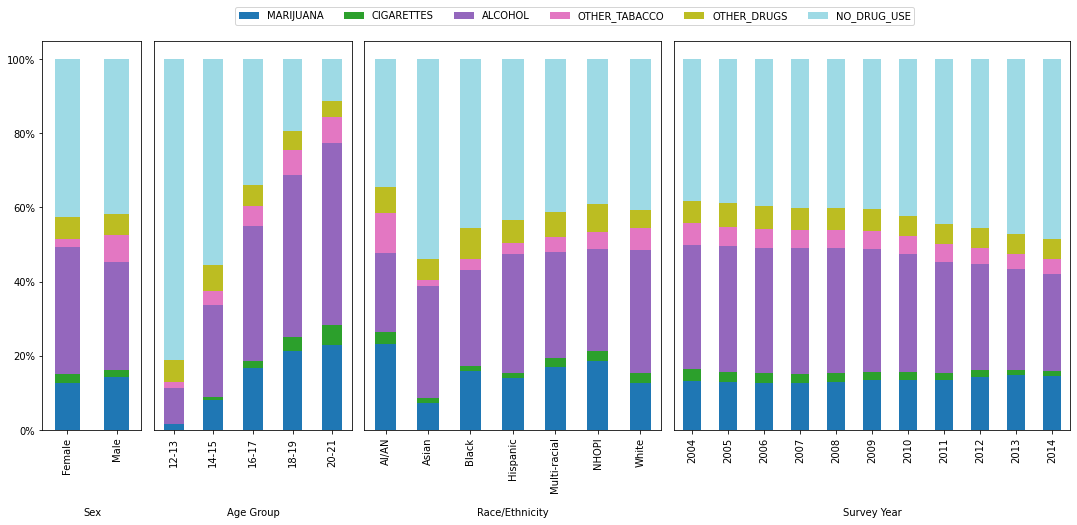

In [9]:
figure, axis = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 2, 3, 4]})
figure.set_size_inches(15, 6, forward=True)
figure.tight_layout() 
prop_sex[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[0], legend=None, xlabel='Sex')
prop_age[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[1], legend=None, xlabel='Age Group')
prop_race[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[2], legend=None, xlabel='Race/Ethnicity')
prop_year[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[3], legend=None, xlabel='Survey Year')
axis[0].yaxis.set_major_formatter('{x:1.0f}%')
axis[1].set_yticks([])
axis[2].set_yticks([])
axis[3].set_yticks([])
axis[0].xaxis.set_label_coords(.5, -.2)
axis[1].xaxis.set_label_coords(.5, -.2)
axis[2].xaxis.set_label_coords(.5, -.2)
axis[3].xaxis.set_label_coords(.5, -.2)
plt.subplots_adjust(wspace=0.05)
plt.legend(loc='upper center', bbox_to_anchor=(-0.25, 1.1),  ncol = 6)
# plt.savefig('figure_1.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.5)
plt.show()

# Plot Table 1

In [10]:
from scipy.stats.contingency import relative_risk
import scipy.stats

In [11]:
scipy.__version__

'1.7.2'

In [12]:
tables = []
for pair in [('MARIJUANA', 'NO_DRUG_USE'), ('MARIJUANA', 'CIGARETTES'), ('MARIJUANA', 'ALCOHOL')]:
    data = df[df.CLASS.isin(pair)][['CLASS', 'SEX']]
    tables.append(data)
marijuanna_vs_no_drugs = tables[0]
marijuanna_vs_no_drugs.shape

(165066, 2)

In [13]:
marijuanna_vs_no_drugs.head(2)

,CLASS,SEX
0,MARIJUANA,Male
1,MARIJUANA,Female


In [14]:
table = marijuanna_vs_no_drugs.pivot_table(index='SEX', columns='CLASS', aggfunc=len)
table

CLASS,MARIJUANA,NO_DRUG_USE
SEX,,
Female,18706,62843
Male,21208,62309


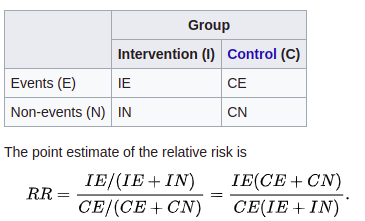

In [32]:
MM = table.iloc[1, 0]
MF = table.iloc[0, 0]
NM = table.iloc[1, 1]
NF = table.iloc[0, 1]
MM, MF, NM, NF

(21208, 18706, 62309, 62843)

In [33]:
result = relative_risk(MM, MM + NM, MF, MF + NF)
result.relative_risk

1.10703802596475

-------------------------------